# Script for Cleanong raw files

In [22]:
#import required libraries|
import os
import pandas as pd
import numpy as np
import datetime
from IPython.display import clear_output
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

In [23]:
def copy_PATH(src  = '/media/rdverse/Hippocampus/faceData/data', dest = '.'):
    """ create a link for data path in current dir
    args:
        dest (str) : where you want to create the symbolic link
    Returns:
        PATH of data directory
    """
    
    while not os.path.isdir(src):
        src = input("Enter path of data dir here")
                
    if not os.path.exists('data'):
        os.symlink(PATH, 'data')

    return 'data'

PATH = copy_PATH() 


# Functions to clean raw data file

In [96]:
def _get_resultants(dataDf):
    """ get resultant columns for 'Accel_LN_', 'Accel_WR_', 'Gyro_','Mag_'

    Args:
        dataDf (data frame): loaded raw dataFrame 

    Returns:
        dataframe: data frame with added resultant columns
    """
    colsNeeded = ['Accel_LN_', 'Accel_WR_', 'Gyro_','Mag_']
    
    for colRes in colsNeeded:
        try:
            dataDf['Resultant_' + colRes] = np.sqrt(np.square(dataDf[colRes + 'X_CAL']) + 
                                            np.square(dataDf[colRes + 'Y_CAL']) + 
                                            np.square(dataDf[colRes + 'Z_CAL']))
        except:
            print("Issue with %s" % colRes)

    return dataDf

def process_rawdata(PATH):
    """Shimmer is not the best in saving csv files. This function takes care of it. Just pass the PATH of file you need

    Args:
        PATH (str): PATH of the file 

    Returns:
        data frame: data loaded and returned as a dataframe
    """
    #read file
    dataDf = pd.read_csv(PATH, sep = '\t', header=0)
    #drop last col with nan
    dataDf.dropna(axis=1, inplace = True)
    #rename cols
    newColNames = [name + '_' + dataDf.iloc[1].values[i] for i,name in enumerate(dataDf.iloc[0].values)]
    # change header
    dataDf = dataDf.set_axis(newColNames, axis=1, inplace=False)[3:].reset_index(drop=True)
    # switch values to float
    dataDf = dataDf.astype(float)
    # get resultant vals
    dataDf = _get_resultants(dataDf)
    # return df
    return dataDf

def get_resultants(dataDf):
    """load resultant

    Args:
        dataDf (pd : df): loaded dataframe with raw data

    Returns:
        pd : df: loaded df with resultant columns
    """
    
    colsNeeded = ['Accel_LN_', 'Accel_WR_', 'Gyro_','Mag_']
    
    for colRes in colsNeeded:
        try:
            dataDf['Resultant_' + colRes] = np.sqrt(np.square(dataDf[colRes + 'X_CAL']) + 
                                            np.square(dataDf[colRes + 'Y_CAL']) + 
                                            np.square(dataDf[colRes + 'Z_CAL']))
        except:
            print("Issue with %s" % colRes)

    return dataDf
    
def process_rawdata(PATH):
    """load raw data

    Args:
        PATH (str): path to the file

    Returns:
        pd : df: raw data with resultant and timestamp loaded
    """
    #read file
    dataDf = pd.read_csv(PATH, sep = '\t', header=0)
    #drop last col with nan
    dataDf.dropna(axis=1, inplace = True)
    #rename cols
    newColNames = [name + '_' + dataDf.iloc[1].values[i] for i,name in enumerate(dataDf.iloc[0].values)]
    # change header
    dataDf = dataDf.set_axis(newColNames, axis=1, inplace=False)[3:].reset_index(drop=True)
    # switch values to float
    dataDf = dataDf.astype(float)
    # get resultant vals
    dataDf = get_resultants(dataDf)
    # add time to df
    rawTime = file_name_splitter(PATH, type='d')
    dataDf['TimeStamp'] = [datetime.datetime.strptime(str(rawTime), "%Y%m%d%H%M%S") +
                       datetime.timedelta(0,v/102.4) for v in dataDf.index+1]
    # return df
    return dataDf

# String operations

In [97]:
'''
function : digit
--------
'''
def digit_splitter(name, type='d'):
    if type=='d':
        item = ''.join([n for n in name if n.isdigit()])
        item = int(item)
    
    else:
        item = ''.join([n for n in name if not n.isdigit()])
    return item


In [107]:
def file_name_splitter(name, type='d'):
    """
    get file name or the date string
    Args:
        name ([type]): [description]
        type (str, optional): [description]. Defaults to 'd'.

    Returns:
        str: string or filename
    """
    if type=='d':
        item = ''.join([n for n in name if n.isdigit()])
        item = int(item)
    
    else:
        item = ''.join([n for n in name if not n.isdigit()])
    return item

def _get_raw_tag_df(root, file):
    """ Load dfs

    Args:
        root (str): root name of file
        file (str): file name

    Returns:
        (df, df): 2 raw and tag dfs 
    """
    filePathRaw = os.path.join(root, file)
    filePathTag = os.path.join("data/unclean/tags/" + root[-1], file_name_splitter(file, type='s'))
    rawDf = process_rawdata(filePathRaw)
    #rawDf=True
    tagDf = pd.read_csv(filePathTag)
    return rawDf, tagDf

In [ ]:
def _pull_pid(name):
    name = file_name_splitter(name,type='s')
    name = name.split('_')[0]
    return name

def _pull_description(name):
    """ get the activity description
    Args:
        name (str): fileName 
    Returns:
        str: activity description
    """
    name = file_name_splitter(name,type='s')
    desc = name.strip('.csv').split("_")[1:]
    desc = '_'.join(desc)
    return desc

def _pull_label(name):
    """get the activity description

   Args:
        name (str): fileName 

    Returns:
        str: activity label (1,0)
    """
    name = file_name_splitter(name,type='s')
    if name.split('_')[1] in ['le', 're', 'n', 'm']:
        label = 1
    else:
        label = 0
    return label

def _pull_feature(root, file, sliceLen):
    """ takes a single df and extracts features

    Args:
        root (str): root name of file
        file (str): file name

    Returns:
        [type]: features df either static or dynamic
    """
    feats =list()
    rawDf, tagDf = _get_raw_tag_df(root, file)
    # filter touch points
    tagDf = tagDf[tagDf["status"]=="y"]

    fileParts = file.strip(".csv").split("_")

    feats = list()
    if fileParts[2]==fileParts[1]:
        feats = __type_static(rawDf,tagDf, sliceLen)
    else:
        feats = __type_dynamic(rawDf,tagDf, sliceLen)

    return feats

def __type_dynamic(rawDf, tagDf, sliceLen):
    """ for dynamic activities

    Args:
        rawDf (df): raw data
        tagDf (df): tags data

    Returns:
        features
    """
    feats = list()
    for tPoint in tagDf.time.values:
        try:
            index = rawDf.iloc[rawDf.set_index('TimeStamp').index.get_loc(tPoint ,method='nearest')].name
            
            #feat = rawDf.Resultant_Accel_LN_[index-30:index+20].values
            feat = rawDf[["Accel_LN_X_CAL","Accel_LN_Y_CAL","Accel_LN_Z_CAL",
              "Resultant_Accel_LN_",
               "Gyro_X_CAL", "Gyro_Y_CAL", "Gyro_Z_CAL",
                "Resultant_Gyro_"]][index-sliceLen:index].values#.flatten()
            
            if feat.shape==(sliceLen,8):
                feats.append(feat)
        
        except:
            pass
    
    print("dynamic feats shape {}".format(np.array(feats).shape))
    return feats|

def __type_static(rawDf,tagDf, sliceLen):
    """ for static activities

    Args:
        rawDf (df): raw data
        tagDf (df): tags data

    Returns:
        features
    """
    feats = list()
    length = len(rawDf)
    rawDf = rawDf[300:length-300]
    
    length = sliceLen*20#len(rawDf) - len(rawDf)%50
    rawDf = rawDf[:length]

    #feats = rawDf.Resultant_Accel_LN_.values.reshape(int(length/50),50)
    feats = rawDf[["Accel_LN_X_CAL","Accel_LN_Y_CAL","Accel_LN_Z_CAL",  
    "Resultant_Accel_LN_", "Gyro_X_CAL",
     "Gyro_Y_CAL", "Gyro_Z_CAL",
      "Resultant_Gyro_"]].values.reshape(int(length/sliceLen),sliceLen,8)[:20]#.flatten().reshape(int(length/50),150)
    
    print("static feats shape {}".format(np.array(feats).shape))
    feats = list(feats)
    #print("static feats length %d" %len(feats))
    return feats

In [99]:
%ls data/unclean/raw/a

20210911110355a_le_sit.csv  20210911112256a_sc_sta.csv
20210911110525a_re_sit.csv  20210911112407a_sh_sta.csv
20210911110700a_n_sit.csv   20210911112525a_i_sta.csv
20210911110859a_m_sit.csv   20210911112654a_sta_sta.csv
20210911111048a_le_sta.csv  20210911112916a_sit_sit.csv
20210911111344a_re_sta.csv  20210911113108a_sc_sit.csv
20210911111459a_n_sta.csv   20210911113250a_sh_sit.csv
20210911111608a_m_sta.csv   20210911113404a_i_sit.csv
20210911111746a_le_wal.csv  20210911113529a_sc_wal.csv
20210911111901a_re_wal.csv  20210911113909a_sh_wal.csv
20210911112015a_n_wal.csv   20210911114037a_i_wal.csv
20210911112125a_m_wal.csv   20210911114145a_wal_wal.csv


# Load raw data and tags Files

In [101]:
# fileName = "a_m_sit.csv"

# tagsDf = pd.read_csv(os.path.join("data/unclean/tags", fileName), index_col=[0])

# dataDf = process_rawdata(os.path.join("data/unclean/raw/b/20210910171401b_m_sit.csv")

# tagsDf['time'] = pd.to_datetime(tagsDf.time) + datetime.timedelta(0,1)

In [102]:
# import datetime
# datetime.datetime.strptime('20210910105115', "%Y%m%d%H%M%S") + datetime.timedelta(0,1)

In [132]:
# dataDf['TimeStamp'] = [datetime.datetime.strptime('20210910105115', "%Y%m%d%H%M%S") +
#                        datetime.timedelta(0,v/51) for v in dataDf.index+1]

In [133]:
tagsDf.columns

Index(['Unnamed: 0', 'time', 'status'], dtype='object')

In [147]:
dataDf,tagsDf = _get_raw_tag_df("data/unclean/raw/a", "20210911111048a_le_sta.csv"  )
tagsDf.drop(columns = ["Unnamed: 0"], inplace = True)

In [196]:
def get_rcParams(plt):
    plt.rcParams['font.size'] = 12
    plt.rcParams['hatch.linewidth'] = 0.25
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'
    plt.rcParams['figure.dpi'] = 600
    plt.rcParams["lines.linewidth"] = 1
    plt.rcParams['hatch.linewidth'] = 0.15
    return plt

In [201]:
dataDf.TimeStamp[indexStart:indexEnd].values[[1,3,5]]

array(['2021-09-11T11:10:52.687500000', '2021-09-11T11:10:52.707031000',
       '2021-09-11T11:10:52.726562000'], dtype='datetime64[ns]')

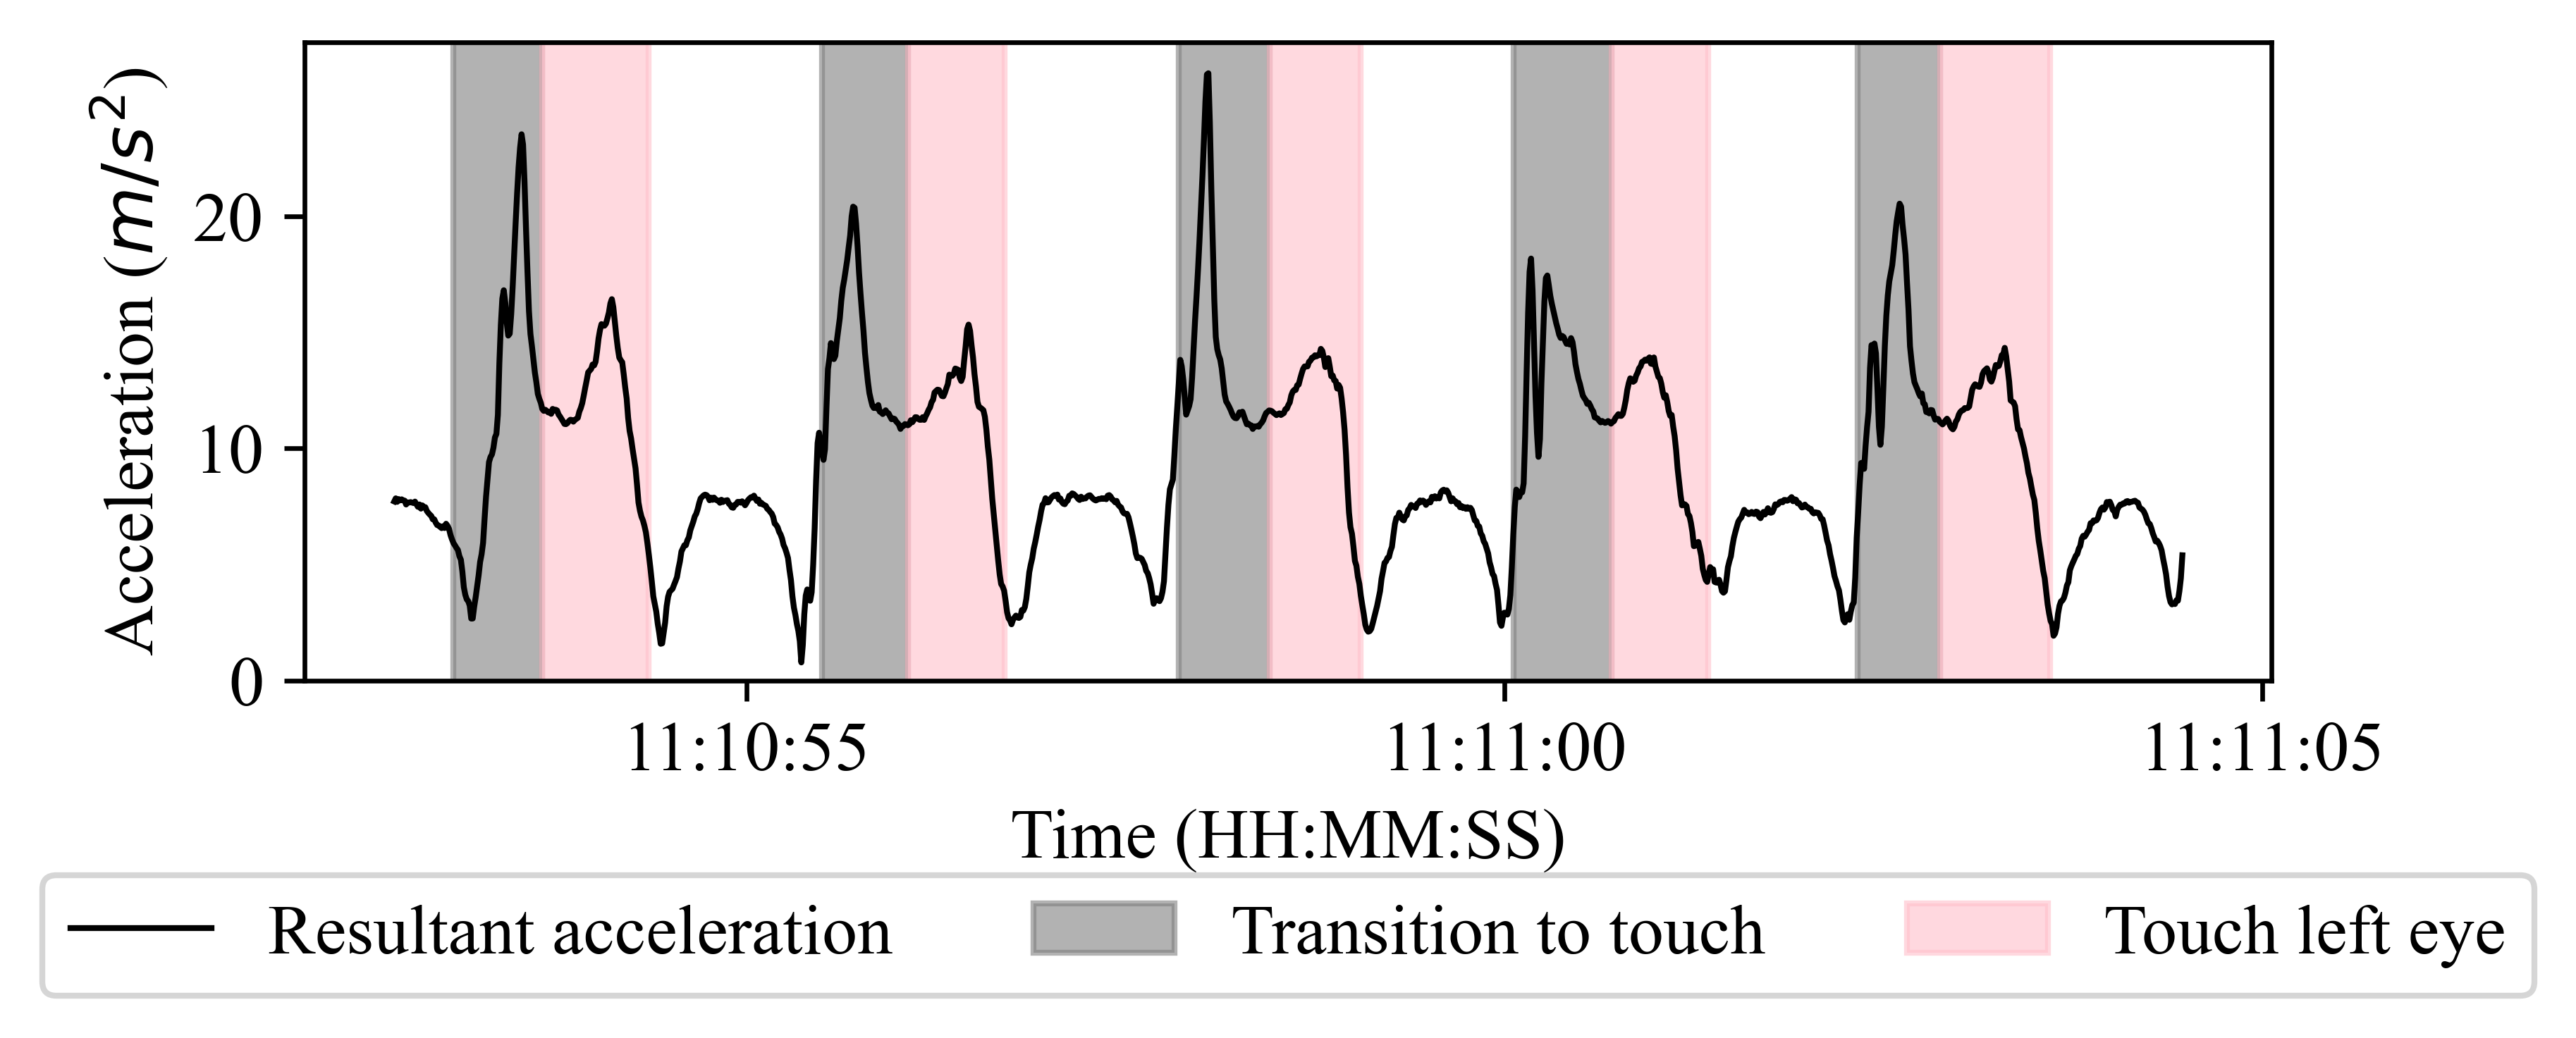

In [224]:
# start
s = 6
# multiples
m = 5
# end
e = s + m*3

indexStart = dataDf.iloc[dataDf.set_index('TimeStamp').index.get_loc(tagsDf.time.iloc[s] ,method='nearest')].name -40
indexEnd = dataDf.iloc[dataDf.set_index('TimeStamp').index.get_loc(tagsDf.time.iloc[e] ,method='nearest')].name -20

plt = get_rcParams(plt)

fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot()

ax.plot(dataDf.TimeStamp[indexStart:indexEnd], dataDf.Resultant_Accel_LN_[indexStart:indexEnd], color='black', label = "Resultant acceleration")

for i,bar in enumerate(tagsDf[s:e].values.reshape( int(len(tagsDf[s:e])/3),3,2)):

    times = np.take(bar,0, axis=1)
    # times = [t - datetime.timedelta(0,1) for t in times]
    a = times[0]
    b = times[1]
    vals = dataDf.Resultant_Accel_LN_[20:]
    #vals = [0,25]
    maxVal = 27.5
    if i==0:
        ax.fill_between([times[0],times[1]], np.min(vals)-1, maxVal, alpha =0.6, color = 'gray', label = "Transition to touch")
        ax.fill_between([times[1],times[2]], np.min(vals)-1, maxVal, alpha =0.6, color = 'pink', label = "Touch left eye")
    else:
        ax.fill_between([times[0],times[1]], np.min(vals)-1, maxVal, alpha =0.6, color = 'gray')
        ax.fill_between([times[1],times[2]], np.min(vals)-1, maxVal, alpha =0.6, color = 'pink')
# plt.xticks(dataDf.TimeStamp[indexStart:indexEnd].values[[0,-1]])
ax.set_ylim(0,maxVal)
ax.set_ylabel("Acceleration ($m/s^{2}$)")
ax.set_xlabel("Time (HH:MM:SS)")
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center',  bbox_to_anchor=(0.5, -.25), ncol=3)
# lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.25), ncol=3)
# plt.tight_layout()
fig.savefig("leTouch.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [189]:
tagsDf[s:e].values.reshape(len(tagsDf[s:e]),3,2)

ValueError: cannot reshape array of size 30 into shape (15,3,2)

In [192]:
plt.xticks

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

In [139]:
tagsDf[s:e].values

array([['2021-09-11 11:10:53.068216', 't'],
       ['2021-09-11 11:10:53.652395', 'y'],
       ['2021-09-11 11:10:54.356494', 'u'],
       ['2021-09-11 11:10:55.500597', 't'],
       ['2021-09-11 11:10:56.068457', 'y'],
       ['2021-09-11 11:10:56.705063', 'u'],
       ['2021-09-11 11:10:57.852346', 't'],
       ['2021-09-11 11:10:58.452224', 'y'],
       ['2021-09-11 11:10:59.052256', 'u'],
       ['2021-09-11 11:11:00.060623', 't'],
       ['2021-09-11 11:11:00.708430', 'y'],
       ['2021-09-11 11:11:01.348442', 'u'],
       ['2021-09-11 11:11:02.332942', 't'],
       ['2021-09-11 11:11:02.876400', 'y'],
       ['2021-09-11 11:11:03.604225', 'u']], dtype=object)

In [112]:
dataDf["TimeStamp"][index]

Timestamp('2021-09-11 11:10:50.958984')

In [115]:
tagsDf.time.iloc[3]

'2021-09-11 11:10:50.955571'

In [116]:
tagsDf.shape

(57, 3)

# proper plot

In [ ]:
plt.figure(figsize = (7,5),dpi=120)

s = 1000
e = 2000
dataCrop = dataDf[s:e]
tagsCrop = tagsDf[]

plt.plot(dataCrop.TimeStamp,dataCrop.Resultant_Accel_LN_, color='black', label = "Resultant acceleration")

# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_X_CAL[2000:3000], label = 'x-Accel')
# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_Y_CAL[2000:3000], label = 'y-Accel')
# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_Z_CAL[2000:3000], label = 'z-Accel')

plt.xticks(rotation=45)

# d = data['Date'].values
# plt.fill_between(d, data['A'], data['B'],
#                 where=data['A'] >= data['B'],
#                 facecolor='green', alpha=0.2, interpolate=True)


for i,bar in enumerate(tagsDf.values.reshape(17,3,2)[10:15]):
    times = np.take(bar,0, axis=1)
    times = [t - datetime.timedelta(0,1) for t in times]
    a = times[0]
    b = times[1]
    vals = dataDf.Resultant_Accel_LN_[20:]
    #vals = [0,25]
    if i==0:
        plt.fill_between([times[0],times[1]], np.min(vals), np.max(vals), alpha =0.6, color = 'gray', label = "transition to touch")
        plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'pink', label = "touch left eye")
    else:
        plt.fill_between([times[0],times[1]], np.min(vals), np.max(vals), alpha =0.6, color = 'gray')
        plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'pink')
        
plt.xlabel("Time (HH:MM:SS)")
    #plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'yellow')

    # #     plt.fill_between(np.take(bar,0))
    
# #     print(np.take(bar,0))
# #     pos= np.sum(np.take(bar,0))
# #     print(pos)
#     plt.bar(np.take(bar,0), 27.5, datetime.timedelta(0,20))
    
#     val= [max_val]
#     width = [bar[2][0]-bar[0][0]]
#     ax2.bar(pos,val,width, color = 'black', alpha = 0.1)
plt.legend()
plt.savefig("r.png")
plt.show()
#plt.bar()
%matplotlib inline

# old plot

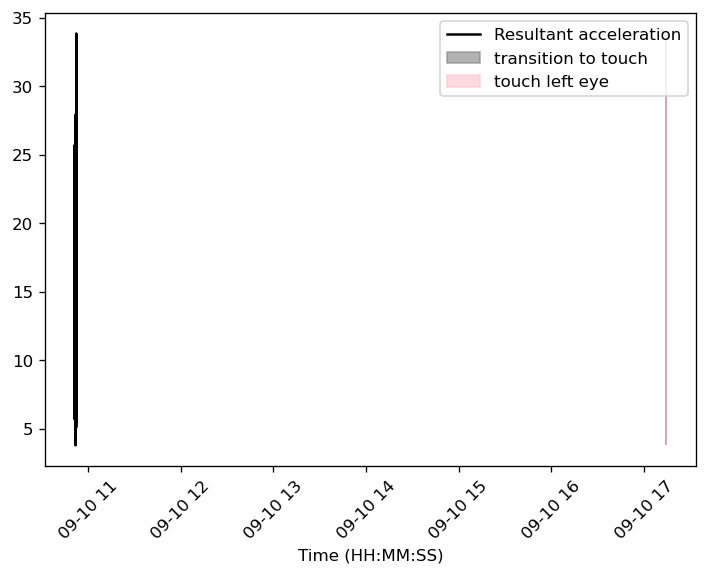

In [12]:
plt.figure(figsize = (7,5),dpi=120)

#plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Resultant_Accel_LN_[:1000])

s = 1000
e = 2000
dataCrop = dataDf[s:e]
tagsCrop = tagsDf
plt.plot(dataCrop.TimeStamp,dataCrop.Resultant_Accel_LN_, color='black', label = "Resultant acceleration")

# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_X_CAL[2000:3000], label = 'x-Accel')
# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_Y_CAL[2000:3000], label = 'y-Accel')
# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_Z_CAL[2000:3000], label = 'z-Accel')

plt.xticks(rotation=45)

# d = data['Date'].values
# plt.fill_between(d, data['A'], data['B'],
#                 where=data['A'] >= data['B'],
#                 facecolor='green', alpha=0.2, interpolate=True)


for i,bar in enumerate(tagsDf.values.reshape(17,3,2)[10:15]):
    times = np.take(bar,0, axis=1)
    times = [t - datetime.timedelta(0,1) for t in times]
    a = times[0]
    b = times[1]
    vals = dataDf.Resultant_Accel_LN_[20:]
    #vals = [0,25]
    if i==0:
        plt.fill_between([times[0],times[1]], np.min(vals), np.max(vals), alpha =0.6, color = 'gray', label = "transition to touch")
        plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'pink', label = "touch left eye")
    else:
        plt.fill_between([times[0],times[1]], np.min(vals), np.max(vals), alpha =0.6, color = 'gray')
        plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'pink')
        
plt.xlabel("Time (HH:MM:SS)")
    #plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'yellow')

    # #     plt.fill_between(np.take(bar,0))
    
# #     print(np.take(bar,0))
# #     pos= np.sum(np.take(bar,0))
# #     print(pos)
#     plt.bar(np.take(bar,0), 27.5, datetime.timedelta(0,20))
    
#     val= [max_val]
#     width = [bar[2][0]-bar[0][0]]
#     ax2.bar(pos,val,width, color = 'black', alpha = 0.1)
plt.legend()
plt.savefig("r.png")
plt.show()
#plt.bar()
%matplotlib inline

In [27]:
tagsDf.values.shape[0][1].shape

TypeError: 'int' object is not subscriptable

In [211]:
tagsDf.values.reshape(27,3,2)[:4]

array([[[Timestamp('2021-09-10 10:51:18.262964'), 't'],
        [Timestamp('2021-09-10 10:51:18.868621'), 'y'],
        [Timestamp('2021-09-10 10:51:19.556485'), 'u']],

       [[Timestamp('2021-09-10 10:51:20.405710'), 't'],
        [Timestamp('2021-09-10 10:51:20.976593'), 'y'],
        [Timestamp('2021-09-10 10:51:21.534269'), 'u']],

       [[Timestamp('2021-09-10 10:51:22.402140'), 't'],
        [Timestamp('2021-09-10 10:51:22.926471'), 'y'],
        [Timestamp('2021-09-10 10:51:23.642457'), 'u']],

       [[Timestamp('2021-09-10 10:51:24.369033'), 't'],
        [Timestamp('2021-09-10 10:51:25.001542'), 'y'],
        [Timestamp('2021-09-10 10:51:25.644294'), 'u']]], dtype=object)

In [203]:
bar

array([Timestamp('2021-09-10 10:51:26.539843'), 't'], dtype=object)

In [171]:
81/3

27.0